In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from scipy import stats

# # Read in Data

In [2]:
path="/Users/guoyalong/Downloads/injuries_2010-2020.csv"
path2="/Users/guoyalong/Downloads/Team_Records.csv"

In [3]:
#read in Team_records file
Team_records=pd.read_csv(path2)
Team_records.head()

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,NaN,B. Stevens (29-10),K. Irving (5.7)
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5)
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7)
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5)
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,NaN,B. Stevens (25-57),B. Bass (5.1)


In [4]:
#read in injuries csv file
injuries_2010_2020=pd.read_csv(path)
injuries_2010_2020.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


## Clean up Injuries Data

In [5]:
#drop the acquired column 
new_injuries_df=injuries_2010_2020.loc[:,["Date","Team","Relinquished","Notes"]]
new_injuries_df

,Date,Team,Relinquished,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...
27100,2020-09-30,Lakers,NaN,activated from IL
27101,2020-10-02,Heat,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,Goran Dragic,placed on IL with torn plantar fascia in left ...
27103,2020-10-02,Heat,NaN,activated from IL


In [6]:
#get unique number of teams
new_injuries_df["Team"].nunique()

32

In [7]:
#get names of teams
teams=new_injuries_df["Team"].unique()
teams

array(['Bulls', 'Pistons', 'Blazers', 'Nets', 'Nuggets', 'Bucks', 'Kings',
       'Bobcats', 'Warriors', 'Suns', 'Heat', 'Thunder', 'Timberwolves',
       'Celtics', 'Lakers', 'Rockets', '76ers', 'Cavaliers', 'Clippers',
       'Grizzlies', 'Hawks', 'Hornets', 'Jazz', 'Knicks', 'Mavericks',
       'Pacers', 'Raptors', 'Spurs', 'Magic', 'Wizards', 'Pelicans', nan,
       'Bullets'], dtype=object)

In [8]:
#drop null values for relinquished
cleaned_injuries_df=new_injuries_df.dropna(subset=["Relinquished"])
cleaned_injuries_df

,Date,Team,Relinquished,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...
27097,2020-09-22,Celtics,Romeo Langford,surgery on right wrist (out for season)
27098,2020-09-23,Heat,Gabe Vincent,sore right knee (DTD)
27099,2020-09-30,Heat,Bam Adebayo,strained left shoulder (DTD)
27101,2020-10-02,Heat,Bam Adebayo,strained neck (DTD)


In [9]:
#Total number of players that did play due to injury or other reason
cleaned_injuries_df["Relinquished"].count()

17560

# # Figure out the most Common Injury

In [10]:
target_word = 'knee'
knee_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word)).sum()
knee_injuries_count

2714

In [11]:
target_word_2 = 'foot'
foot_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_2)).sum()
foot_injuries_count

756

In [12]:
target_word_3 = 'back'
back_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_3)).sum()
back_injuries_count

964

In [13]:
target_word_4 = 'shoulder'
shoulder_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_4)).sum()
shoulder_injuries_count

532

In [14]:
target_word_5 = 'wrist'
wrist_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_5)).sum()
wrist_injuries_count

261

In [15]:
target_word_6 = 'finger'
finger_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_6)).sum()
finger_injuries_count

133

In [16]:
target_word_7 = 'hip'
hip_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_7)).sum()
hip_injuries_count

425

In [17]:
target_word_8 = 'Achilles'
achilles_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_8)).sum()
achilles_injuries_count

263

In [18]:
target_word_9 = 'groin'
groin_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_9)).sum()
groin_injuries_count

372

In [19]:
target_word_10 = 'shin'
shin_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_10)).sum()
shin_injuries_count

46

In [20]:
target_word_11 = 'hand'
hand_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_11)).sum()
hand_injuries_count

203

In [21]:
target_word_12 = 'ankle'
ankle_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_12)).sum()
ankle_injuries_count

2185

In [22]:
target_word_13 = 'hamstring'
hamstring_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_13)).sum()
hamstring_injuries_count

649

In [23]:
target_word_14 = 'neck'
neck_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_14)).sum()
neck_injuries_count

102

In [24]:
target_word_15 = 'eye'
eye_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_15)).sum()
eye_injuries_count

71

In [25]:
target_word_16 = 'abductor'
abductor_injuries_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_16)).sum()
abductor_injuries_count

13

In [26]:
target_word_17 = 'illness'
illness_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_17)).sum()
illness_count

664

In [27]:
target_word_18 = 'flu'
flu_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_18)).sum()
flu_count

180

In [28]:
target_word_19 = 'stomach'
stomach_count = cleaned_injuries_df['Notes'].apply(lambda x: x.split().count(target_word_19)).sum()
stomach_count

96

In [29]:
total_illness_count= illness_count+flu_count+stomach_count
total_illness_count

940

Text(0.5, 1.0, '2010-2020 Most Common Types of Injuries')

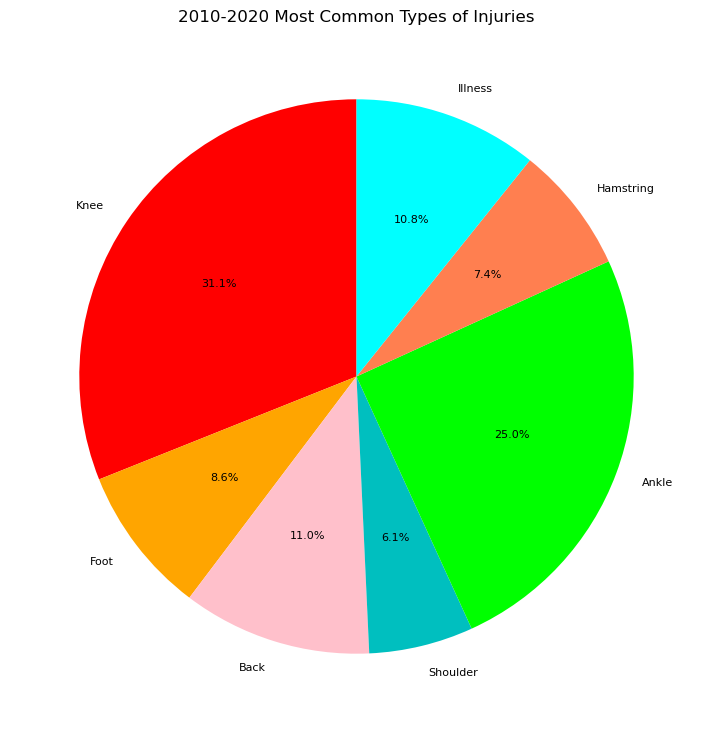

In [30]:
location = ['Knee', 'Foot', 'Back', 'Shoulder','Ankle','Hamstring','Illness']
numbers = [2714,756,964,532,2185,649,940]

plt.figure(figsize=(9, 9))
plt.pie(numbers, labels=location, autopct='%1.1f%%', startangle=90, colors=['red','orange','pink','c','lime','coral','cyan'],textprops=dict(fontsize=8, color='black'))

plt.title('2010-2020 Most Common Types of Injuries')

The pie chart above depicts the most common injuries sustained throughout 2010-2020. Illness was added as well, just to see the comparsion with injuries. Knee injuries were the most frequent with ankle injuries following close behind. There were also other injuries not included in the pie chart, but included with the data sorting, because they were not significant. 


# # Find the Total Number of Injuries per Team

In [24]:
#groupby teams and players
clean_injuries_grouped = cleaned_injuries_df.groupby('Team')['Relinquished'].count().reset_index()

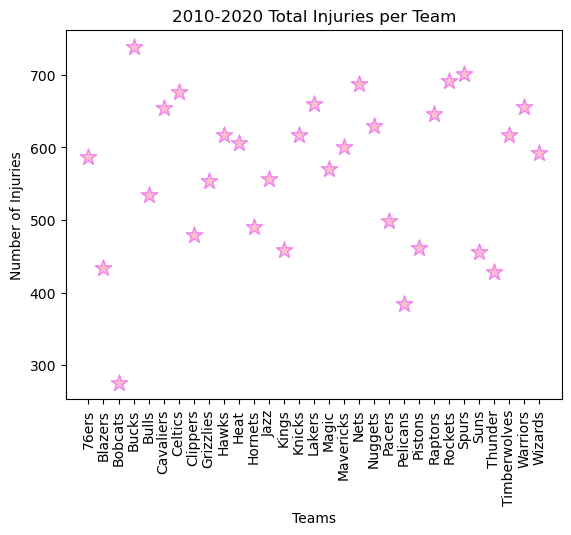

In [25]:
#2010-2020 Total Injuries
plt.scatter(clean_injuries_grouped['Team'], clean_injuries_grouped['Relinquished'],marker="*",color='violet',facecolor="pink",s=150)
plt.title("2010-2020 Total Injuries per Team")
plt.xlabel("Teams")
plt.ylabel("Number of Injuries")
plt.xticks(rotation=90)
plt.show()

This chart shows the total injuries per team from 2010-2020. We can see the Bucks sustained the most amount of injuries from these years, whereas the Bobcats suffered the least amount.

# # Sort Data by Year

In [26]:
cleaned_injuries_df['Date'] = pd.to_datetime(cleaned_injuries_df['Date'])
target_year=2015
fifteen=cleaned_injuries_df[cleaned_injuries_df['Date'].dt.year == target_year]
fifteen

/var/folders/rq/8wkmsgts1890_697cdk3rnd00000gn/T/ipykernel_12023/2909445291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_injuries_df['Date'] = pd.to_datetime(cleaned_injuries_df['Date'])


,Date,Team,Relinquished,Notes
11372,2015-01-01,Kings,Omri Casspi,placed on IL with left knee injury
11375,2015-01-02,Bucks,Larry Sanders,placed on IL
11380,2015-01-02,Jazz,Rodney Hood,left heel injury (out indefinitely)
11381,2015-01-02,Knicks,Carmelo Anthony,sore left knee (DTD)
11382,2015-01-02,Knicks,Tim Hardaway Jr.,placed on IL with concussion
...,...,...,...,...
14066,2015-12-31,Pacers,Ian Mahinmi,placed on IL with knee injury
14069,2015-12-31,Suns,Jon Leuer,ankle injury (DTD)
14070,2015-12-31,Thunder,Steve Novak,placed on IL
14072,2015-12-31,Timberwolves,Kevin Garnett,placed on IL for rest


In [27]:
fifteen.groupby('Team')['Relinquished'].count().reset_index()

,Team,Relinquished
0,76ers,54
1,Blazers,50
2,Bucks,47
3,Bulls,55
4,Cavaliers,48
5,Celtics,40
6,Clippers,41
7,Grizzlies,52
8,Hawks,85
9,Heat,65


In [28]:
target_year=2016
sixteen=cleaned_injuries_df[cleaned_injuries_df['Date'].dt.year == target_year]
sixteen

,Date,Team,Relinquished,Notes
14077,2016-01-01,76ers,Hollis Thompson,corneal abrasion in right eye (DTD)
14078,2016-01-01,Hornets,Al Jefferson,placed on IL recovering from surgery on right ...
14079,2016-01-01,Knicks,Cleanthony Early,placed on IL with knee injury (from gunshot wo...
14080,2016-01-01,Lakers,Kobe Bryant,placed on IL with sore right shoulder
14082,2016-01-01,Mavericks,Devin Harris,back spasms (DTD)
...,...,...,...,...
17038,2016-12-31,Knicks,Kristaps Porzingis,placed on IL with sore left Achilles
17039,2016-12-31,Knicks,Kyle O'Quinn,placed on IL with flu
17041,2016-12-31,Magic,Damjan Rudez,strained right calf (DTD)
17042,2016-12-31,Rockets,Patrick Beverley,sore right wrist (DTD)


In [29]:
sixteen.groupby('Team')['Relinquished'].count().reset_index()

,Team,Relinquished
0,76ers,71
1,Blazers,31
2,Bucks,53
3,Bulls,62
4,Cavaliers,60
5,Celtics,55
6,Clippers,59
7,Grizzlies,57
8,Hawks,36
9,Heat,62


In [30]:
target_year=2017
seventeen=cleaned_injuries_df[cleaned_injuries_df['Date'].dt.year == target_year]
seventeen

,Date,Team,Relinquished,Notes
17048,2017-01-01,Hawks,Taurean Prince,placed on IL
17049,2017-01-01,Heat,Hassan Whiteside,right eye injury (DTD)
17050,2017-01-01,Heat,Justise Winslow,torn labrum in right shoulder (out for season)
17051,2017-01-01,Jazz,George Hill,placed on IL
17052,2017-01-01,Kings,Ty Lawson,sinus fracture (DTD)
...,...,...,...,...
20391,2017-12-30,Spurs,Rudy Gay,placed on IL with bursitis in right heel
20393,2017-12-30,Warriors,Kevon Looney,placed on IL
20398,2017-12-31,Celtics,Jabari Bird,placed on IL
20400,2017-12-31,Grizzlies,Ivan Rabb,placed on IL


In [31]:
seventeen.groupby('Team')['Relinquished'].count().reset_index()

,Team,Relinquished
0,76ers,86
1,Blazers,55
2,Bucks,56
3,Bulls,69
4,Cavaliers,67
5,Celtics,77
6,Clippers,46
7,Grizzlies,77
8,Hawks,71
9,Heat,47


# Clean up Team_Records Data

In [32]:
clean_team_records=Team_records.loc[:,["Season","Team","W","L","W/L%","Finish"]]
clean_team_records

,Season,Team,W,L,W/L%,Finish
0,2017-18,Boston Celtics,29,10,0.744,1
1,2016-17,Boston Celtics*,53,29,0.646,1
2,2015-16,Boston Celtics*,48,34,0.585,2
3,2014-15,Boston Celtics*,40,42,0.488,2
4,2013-14,Boston Celtics,25,57,0.305,4
...,...,...,...,...,...,...
1478,1999-00,Vancouver Grizzlies,22,60,0.268,7
1479,1998-99,Vancouver Grizzlies,8,42,0.160,7
1480,1997-98,Vancouver Grizzlies,19,63,0.232,6
1481,1996-97,Vancouver Grizzlies,14,68,0.171,7


In [33]:
#get name of teams
clean_team_records["Team"].unique()

array(['Boston Celtics', 'Boston Celtics*', 'Toronto Raptors',
       'Toronto Raptors*', 'New York Knicks', 'New York Knicks*',
       'Philadelphia 76ers', 'Philadelphia 76ers*', 'Syracuse Nationals*',
       'Brooklyn Nets', 'Brooklyn Nets*', 'New Jersey Nets',
       'New Jersey Nets*', 'New York Nets', 'New York Nets*',
       'New Jersey Americans', 'Minnesota Timberwolves',
       'Minnesota Timberwolves*', 'Oklahoma City Thunder',
       'Oklahoma City Thunder*', 'Seattle SuperSonics',
       'Seattle SuperSonics*', 'Denver Nuggets', 'Denver Nuggets*',
       'Denver Rockets*', 'Portland Trail Blazers',
       'Portland Trail Blazers*', 'Utah Jazz', 'Utah Jazz*',
       'New Orleans Jazz', 'Cleveland Cavaliers', 'Cleveland Cavaliers*',
       'Detroit Pistons', 'Detroit Pistons*', 'Fort Wayne Pistons*',
       'Fort Wayne Pistons', 'Milwaukee Bucks', 'Milwaukee Bucks*',
       'Indiana Pacers', 'Indiana Pacers*', 'Chicago Bulls',
       'Chicago Bulls*', 'Golden State Warriors'

# Pick Three Random Teams that have Statistics for the same Seasons

In [34]:
Nuggets=clean_team_records.loc[clean_team_records["Team"] =="Denver Nuggets",:]
Nuggets

,Season,Team,W,L,W/L%,Finish
367,2017-18,Denver Nuggets,19,16,0.543,3
368,2016-17,Denver Nuggets,40,42,0.488,4
369,2015-16,Denver Nuggets,33,49,0.402,4
370,2014-15,Denver Nuggets,30,52,0.366,4
371,2013-14,Denver Nuggets,36,46,0.439,4
382,2002-03,Denver Nuggets,17,65,0.207,7
383,2001-02,Denver Nuggets,27,55,0.329,6
384,2000-01,Denver Nuggets,40,42,0.488,6
385,1999-00,Denver Nuggets,35,47,0.427,5
386,1998-99,Denver Nuggets,14,36,0.280,6


In [35]:
Lakers=clean_team_records.loc[clean_team_records["Team"] =="Los Angeles Lakers",:]
Lakers

,Season,Team,W,L,W/L%,Finish
1021,2017-18,Los Angeles Lakers,11,23,0.324,5
1022,2016-17,Los Angeles Lakers,26,56,0.317,4
1023,2015-16,Los Angeles Lakers,17,65,0.207,5
1024,2014-15,Los Angeles Lakers,21,61,0.256,5
1025,2013-14,Los Angeles Lakers,27,55,0.329,5
1034,2004-05,Los Angeles Lakers,34,48,0.415,4
1045,1993-94,Los Angeles Lakers,33,49,0.402,5
1063,1975-76,Los Angeles Lakers,40,42,0.488,4
1064,1974-75,Los Angeles Lakers,30,52,0.366,5


In [36]:
Kings=clean_team_records.loc[clean_team_records["Team"] =="Sacramento Kings",:]
Kings

,Season,Team,W,L,W/L%,Finish
951,2017-18,Sacramento Kings,12,23,0.343,4
952,2016-17,Sacramento Kings,32,50,0.390,3
953,2015-16,Sacramento Kings,33,49,0.402,3
954,2014-15,Sacramento Kings,29,53,0.354,4
955,2013-14,Sacramento Kings,28,54,0.341,4
956,2012-13,Sacramento Kings,28,54,0.341,4
957,2011-12,Sacramento Kings,22,44,0.333,5
958,2010-11,Sacramento Kings,24,58,0.293,5
959,2009-10,Sacramento Kings,25,57,0.305,5
960,2008-09,Sacramento Kings,17,65,0.207,5


Text(0.5, 1.0, '2015 NBA Season Number of Injuries and Total Wins')

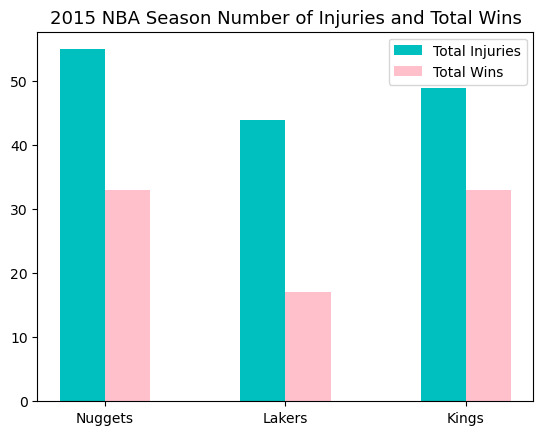

In [37]:
Names_2015 = ['Nuggets', 'Lakers', 'Kings']
Injuries_2015 = [55,44,49]
Wins_2015 = [33,17,33]

bar_width = 0.25
ind = np.arange(len(Names_2015))
fig, ax = plt.subplots()
bar1 = ax.bar(ind - bar_width/2, Injuries_2015, bar_width, label='Total Injuries', color='c')
bar2 = ax.bar(ind + bar_width/2, Wins_2015, bar_width, label='Total Wins', color='pink')
ax.legend()
ax.set_xticks(ind, Names_2015)
ax.set_title('2015 NBA Season Number of Injuries and Total Wins', fontsize=13, color='black')

This chart is for the 2015 NBA season. Total amount of injuries and total amount of wins for this particular season are presented above. The Nuggets and the Kings won the same amount of games for the season, but the number of injuries only differed by six. Although the Lakers suffered fewer injuries, their season wins were less than the other two teams.

Text(0.5, 1.0, '2016 NBA Season Number of Injuries and Total Wins')

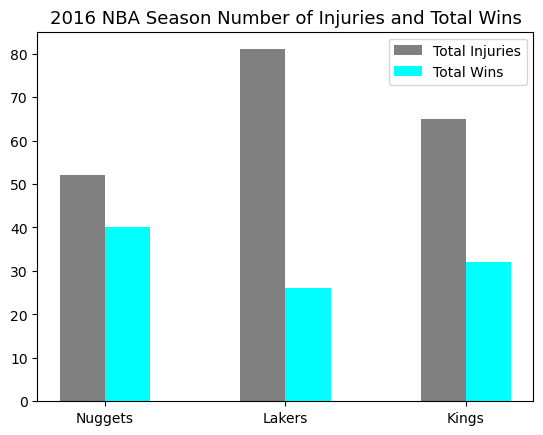

In [38]:
Names_2016 = ['Nuggets', 'Lakers', 'Kings']
Injuries_2016 = [52,81,65]
Wins_2016 = [40,26,32]

bar_width = 0.25
ind = np.arange(len(Names_2015))
fig, ax = plt.subplots()
bar1 = ax.bar(ind - bar_width/2, Injuries_2016, bar_width, label='Total Injuries', color='grey')
bar2 = ax.bar(ind + bar_width/2, Wins_2016, bar_width, label='Total Wins', color='cyan')
ax.legend()
ax.set_xticks(ind, Names_2015)
ax.set_title('2016 NBA Season Number of Injuries and Total Wins', fontsize=13, color='black')

This chart is for the 2016 NBA season. Total amount of injuries and total amount of wins for this particular season are presented above. The Nuggets won the most games out of the other two teams, and additionally accumlated the least amount of injuries as well. The Lakers suffered the most amount of injuries and also lost the most amount of games, in regards to the other two teams.

Text(0.5, 1.0, '2017 NBA Season Number of Injuries and Total Wins')

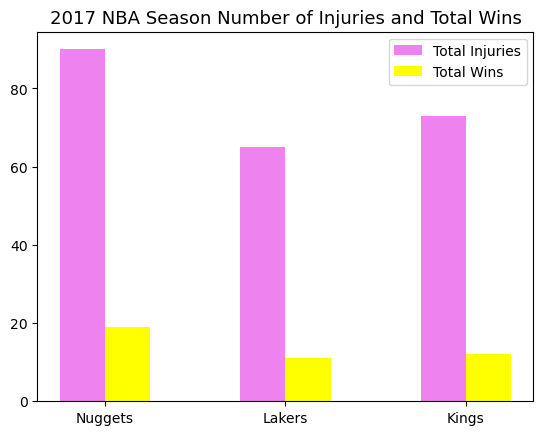

In [39]:
Names_2017 = ['Nuggets', 'Lakers', 'Kings']
Injuries_2017 = [90,65,73]
Wins_2017 = [19,11,12]

bar_width = 0.25
ind = np.arange(len(Names_2015))
fig, ax = plt.subplots()
bar1 = ax.bar(ind - bar_width/2, Injuries_2017, bar_width, label='Total Injuries', color='violet')
bar2 = ax.bar(ind + bar_width/2, Wins_2017, bar_width, label='Total Wins', color='yellow')
ax.legend()
ax.set_xticks(ind, Names_2015)
ax.set_title('2017 NBA Season Number of Injuries and Total Wins', fontsize=13, color='black')

This chart is for the 2017 NBA season. Total amount of injuries and total amount of wins for this particular season are presented above. The Nuggets had the most amount of injuries, but also had the most total wins between the other two teams. The Lakers and the Kings were pretty close with eachother with the total amount of wins and total amount of injuries sustained.